# S2: All cells QC

In [1]:
# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers_1 import *
from scanpy_helpers_2 import *
print ('scanpy version: {}'.format(sc.__version__))
warnings.filterwarnings('ignore')
%matplotlib inline

# read raw data (expression data) to pandas df
pre_adata = (pd.read_csv('s3://daniel.le-work/MEL_project/DL20190115_big_counts.txt', 
                      index_col=[0])
                .rename(columns = {'gene':'gene_name'})
                .set_index('gene_name'))
cell_names = ['_'.join(x.split('_')[:2]) for x in pre_adata.columns]
pre_adata.columns = cell_names

# read fetal supp data
pre_adata_supp1 = (pd.read_csv('s3://daniel.le-work/MEL_project/DL20190319_fetal_v2.csv')
                  .rename(columns = {'gene':'gene_name'})
                   .set_index('gene_name')
                  )

# read adult supp data
pre_adata_supp2 = (pd.read_csv('s3://daniel.le-work/MEL_project/DL20190417_adult_v2.csv')
                  .rename(columns = {'gene':'gene_name'})
                   .set_index('gene_name')
                  )

# merge with raw
pre_adata = pd.concat([pre_adata, pre_adata_supp1,pre_adata_supp2], axis=1)
cell_names = pre_adata.columns.tolist()

# metadata:
## download lastest from google drive and push to s3
meta_df = pd.read_csv('s3://daniel.le-work/MEL_project/DL20190417_mel_metadata.csv')
meta_df = meta_df.drop(['GWAS_consent', 
                        'sort_info_exported',
                       'sort_date',
                       'plate_order',
                       'sample_number',
                       'plate_status'], axis = 1)
possible_wells = [f'{y}{x}'for y in string.ascii_uppercase[:-10] for x in range(1,25)]
all_wells_df = pd.DataFrame()
for plate in meta_df.plate_barcode:
    well_df = pd.DataFrame({'well':possible_wells})
    well_df['plate_barcode'] = plate
    all_wells_df = pd.concat([all_wells_df, well_df], axis = 0)
    
meta_df = pd.merge(meta_df, all_wells_df, 'left', 'plate_barcode')
meta_df['cell_name'] = [f'{x}_{y}' for x,y in zip(meta_df.well, meta_df.plate_barcode)]

merged_anno = pd.merge(pd.DataFrame({'cell_name':cell_names}), meta_df, 'left', 'cell_name')
merged_anno = merged_anno.set_index('cell_name')


/home/ubuntu/anaconda3/lib/python3.7/site-packages/scanpy/api/__init__.py:6: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning


scanpy version: 1.4.4.post1


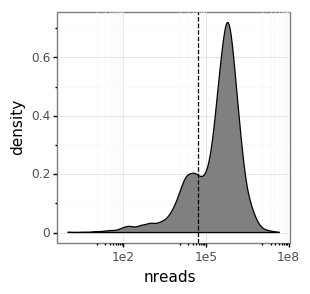

<ggplot: (-9223363277077429872)>


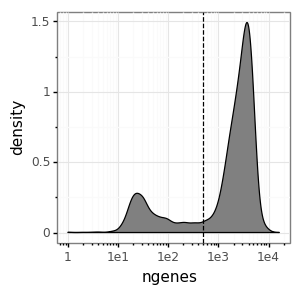

<ggplot: (8759773489970)>


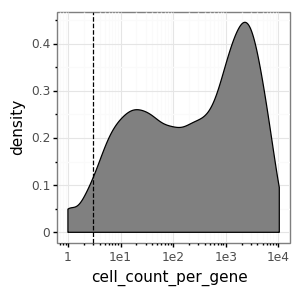

<ggplot: (-9223363277077672879)>


In [2]:
# nreads
dist_df = pd.DataFrame({'nreads':pre_adata.astype(int).sum().values,
                        'ngenes':(pre_adata > 0).sum().values,
                        'cell_id':pre_adata.columns
                       }).set_index('cell_id')
plotnine.options.figure_size = (3,3)

plot = (ggplot(dist_df)
        + theme_bw()
        + geom_density(aes('nreads'), fill='grey')
        + geom_vline(aes(xintercept=50000), linetype='--')
        + scale_x_log10()
       )
print(plot)

# ngenes
plot = (ggplot(dist_df)
        + theme_bw()
        + geom_density(aes('ngenes'), fill='grey')
        + geom_vline(aes(xintercept=500), linetype='--')
        + scale_x_log10()
       )
print(plot)

passing_cells = (dist_df
                 .query('nreads >= 50000')
                 .query('ngenes >= 500')
                 .reset_index()['cell_id']
                 .tolist()
                )
filtered_pre_adata = pre_adata.loc[:, passing_cells]
dist_df2 = pd.DataFrame({'cell_count_per_gene':(filtered_pre_adata > 0).sum(axis=1)
                       })

# n cells per gene
plot = (ggplot(dist_df2)
        + theme_bw()
        + geom_density(aes('cell_count_per_gene'), fill='grey')
        + geom_vline(aes(xintercept=3), linetype='--')
        + scale_x_log10()
       )
print(plot)